In [6]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [7]:
class PolyhedronDataModule(pl.LightningDataModule):
    def __init__(self, num_data, num_edges, coordinate):
        super().__init__()
        data_list_1 = self._create_data("tetrahedron", num_data, num_edges, coordinate, y=1)
        data_list_0 = self._create_data("cube", num_data, num_edges, coordinate, y=0)
        random.shuffle(data_list_1)
        random.shuffle(data_list_0)
        ratio       = 0.8
        num_train   = int(ratio * num_data)
        self.train_dataset = data_list_1[:num_train] + data_list_0[:num_train]
        self.test_dataset  = data_list_1[num_train:] + data_list_0[num_train:]

    def _generate_random_unit_vector(self):
        # for the algorithm, see
        # 1. https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere
        # 2. https://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/
        while True:
            gaussian_vector  = np.random.randn(3)
            vector_magnitude = np.linalg.norm(gaussian_vector)
            if vector_magnitude > 1e-5:
                break
        random_unit_vector = gaussian_vector / vector_magnitude
        return random_unit_vector

    def _rotation_matrix(self, unit_vector, theta):
        # see https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle
        s = np.sin(theta)
        c = np.cos(theta)
        x, y, z = unit_vector
        return np.array([
            [c+x*x*(1-c), x*y*(1-c)-z*s, x*z*(1-c)+y*s],
            [y*x*(1-c)+z*s, c+y*y*(1-c), y*z*(1-c)-x*s],
            [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]
        ])

    def _randomly_rotate(self, nodes):
        # the primary node will always be the [0] node
        primary_node       = nodes[0]
        # randomly choose a unit vector
        random_unit_vector = self._generate_random_unit_vector()
        # get the unit vector perpendicular to the primary node and the random unit vector
        perp_unit_vector   = np.cross(primary_node, random_unit_vector)
        perp_unit_vector   = perp_unit_vector / np.linalg.norm(perp_unit_vector)
        # get the angle between the primary node and the random unit vector
        p, n, v = primary_node, random_unit_vector, perp_unit_vector
        if np.sign(np.dot(p, n)) > 0:
            angle = np.arcsin(min(np.linalg.norm(perp_unit_vector), 1))
        else:
            angle = np.pi-np.arcsin(min(np.linalg.norm(perp_unit_vector), 1))
        # rotate primary nodes and others with angle
        nodes = nodes.T
        nodes = self._rotation_matrix(v, angle) @ nodes
        # rotate an arbitrary angle with axis n
        theta = 2 * np.pi * np.random.rand()
        nodes = self._rotation_matrix(n, theta) @ nodes
        nodes = nodes.T
        return nodes

    def _polyhedron_nodes(self, polyhedron):
        # tetrahedron
        if polyhedron == "tetrahedron":
            return (1/np.sqrt(3)) * np.array([
                [1,1,1], [-1,-1,1], [-1,1,-1], [1,-1,-1]
            ])
        # cube
        elif polyhedron == "cube":
            return (1/np.sqrt(3)) * np.array([
                [1,1,1], [1,1,-1], [1,-1,1], [1,-1,-1],
                [-1,1,1], [-1,1,-1], [-1,-1,1], [-1,-1,-1],
            ])

    def _create_data(self, polyhedron, num_data, num_edges, coordinate, y):
        data_list = []
        for _ in range(num_data):
            # get nodes coordinates
            nodes = self._polyhedron_nodes(polyhedron)
            # first rotating primary nodes to a random vector then random rotate around it
            nodes = self._randomly_rotate(nodes)
            # randomly add a small noise
            nodes = nodes + 1E-3 * np.random.rand(*np.shape(nodes))
            # adding edges, with each node has num_edges edges
            edges = []
            for i in range(len(nodes)):
                # distance between two nodes
                distances = [np.linalg.norm(nodes[i] - nodes[j]) for j in range(len(nodes))]
                # the first arg is trivial self distance
                edges += [(i, idx) for idx in np.argsort(distances)[1:num_edges+1]]
            edges = torch.tensor(edges).transpose(0, 1)
            # select Cartesian coordinates or Spherical coordinates
            nodes = torch.tensor(nodes, dtype=torch.float32)
            # randomly give a bias
            random_unit_bias = torch.rand(nodes.shape[1])
            random_unit_bias = 3 * random_unit_bias / torch.norm(random_unit_bias)
            random_unit_bias = random_unit_bias.repeat(nodes.shape[0], 1)
            nodes = nodes + random_unit_bias
            if coordinate == "cartesian":
                pass
            elif coordinate == "spherical":
                nodes_r     = torch.sqrt(torch.sum(nodes**2, dim=1))
                nodes_theta = torch.acos(nodes[:,2] / nodes_r).reshape(-1, 1)
                nodes_phi   = torch.atan2(nodes[:,1], nodes[:,0]).reshape(-1, 1)
                nodes = torch.cat([nodes_theta, nodes_phi], dim=1)
            else:
                raise ValueError(f"Unknown coordinate type: {coordinate}")
            # check whether nodes are valid -> no nan values
            if torch.any(torch.isnan(nodes)):
                raise ValueError(f"{nodes}")
            data_list.append(Data(x=nodes, edge_index=edges, y=y))
        return data_list

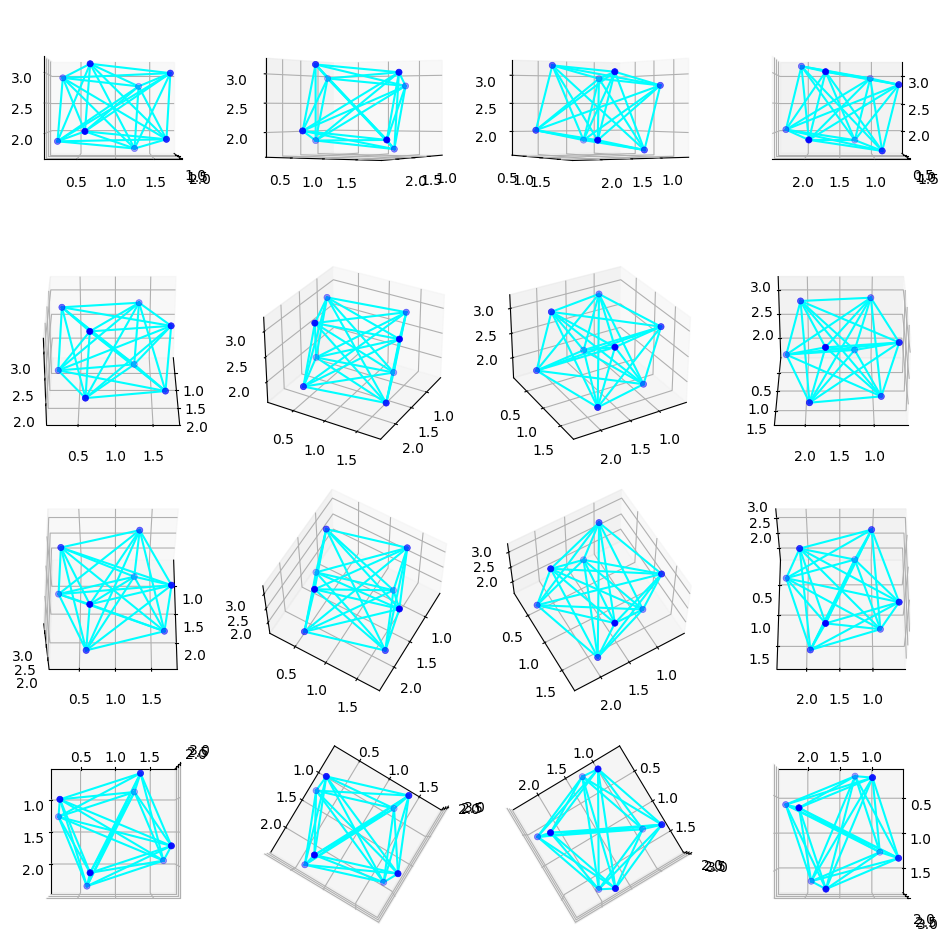

In [71]:
data    = PolyhedronDataModule(100, 3, "cartesian")
idx     = random.choice(range(len(data.train_dataset)))
poly    = data.train_dataset[idx].x
x, y, z = poly.T

num_row = 4
num_col = 4
fig = plt.figure(figsize=(3*num_col, 3*num_row))
for ax_i in range(4):
    for ax_j in range(4):
        ax = fig.add_subplot(num_row, num_col, ax_i*num_col+ax_j+1, projection='3d')
        ax.view_init(30*ax_i, 30*ax_j)
        ax.scatter(x, y, z, color="blue", linewidth=0.5)
        for i in range(len(poly)):
            for j in range(len(poly)):
                if i < j:
                    ax.plot((x[i], x[j]), (y[i], y[j]), (z[i], z[j]), color="cyan")